## Transformers Interpretability/Explainability Notebook

This notebook is a self-contained way to try some explainability techniques for transformer models. The examples currently focus on text classification, but I include links to support other use cases. Over time, I will add more use cases to this notebook.

The notebook currently focuses on:
- [Shap](https://github.com/slundberg/shap) package
- [transformers-interpret](https://github.com/cdpierse/transformers-interpret) 
- Benchmarking multiple explainers with [Ferret XAI](https://github.com/g8a9/ferret)

For more resources:
- You can watch and hear me walk through this notebook on Youtube
- This notebook can be found at [https://bit.ly/raj_explain](https://bit.ly/raj_explain)
- The notebook is also at my GitHub for [huggingface-demos](https://github.com/rajshah4/huggingface-demos/). 
- This complete notebook takes about 20 minutes to run. The slowest parts are the computation of the explanations.

Update History:
August 22, 2022 - Updated Ferret section to run with IMDB Model

## Install Packages

In [1]:
!pip install -q transformers datasets shap transformers-interpret ferret-xai watermark

     |████████████████████████████████| 4.7 MB 2.6 MB/s 
     |████████████████████████████████| 365 kB 54.3 MB/s 
     |████████████████████████████████| 569 kB 46.5 MB/s 
     |████████████████████████████████| 41 kB 268 kB/s 
     |████████████████████████████████| 51 kB 333 kB/s 
     |████████████████████████████████| 101 kB 4.8 MB/s 
     |████████████████████████████████| 6.6 MB 20.5 MB/s 
     |████████████████████████████████| 212 kB 50.8 MB/s 
     |████████████████████████████████| 115 kB 26.6 MB/s 
     |████████████████████████████████| 127 kB 70.2 MB/s 
     |████████████████████████████████| 1.4 MB 43.8 MB/s 
     |████████████████████████████████| 793 kB 70.3 MB/s 
     |████████████████████████████████| 1.6 MB 56.2 MB/s 
     |████████████████████████████████| 275 kB 51.7 MB/s 
     |████████████████████████████████| 1.3 MB 41.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

In [2]:
%load_ext watermark
%watermark

Last updated: 2022-08-22T14:32:33.987480+00:00

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.9.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.188+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import shap
from transformers_interpret import SequenceClassificationExplainer
from ferret import Benchmark


In [4]:
%watermark --iversions

shap: 0.41.0



## Get IMDB Data

Pulling the IMDB dataset which is a binary classification sentiment task on movie reviews.

In [5]:
from datasets import load_dataset

dataset = load_dataset("imdb")
df = dataset['test'].to_pandas()

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Let's grab a few examples and also truncate the data so the text isn't too long

In [6]:
short_data = [v[:500] for v in df["text"][:20]]

## Get Model Trained on IMDB Data

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
tokenizer = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb")
model = AutoModelForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb")

In [8]:
classifier = pipeline('text-classification', return_all_scores=True, model=model,tokenizer=tokenizer)
classifier(short_data[:1])

`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality


[[{'label': 'NEGATIVE', 'score': 0.9332243204116821},
  {'label': 'POSITIVE', 'score': 0.0667756125330925}]]

## Shap 

### Explain predictions from a text classification model

Let's start by using a Shap explainer. For a more extended code walkthrough, check out the complete notebook in the [Shap documentation](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Positive%20vs.%20Negative%20Sentiment%20Classification.html) 

In [9]:
import shap
explainer = shap.Explainer(classifier)

The next step is calculating the shap explanations. If the text is very short (less than ~7 tokens), the Shap packaged does an exact shap calculation. For longer lengths, shap uses the partition explainer to approximate the shap values. Even with the partition explainer, it takes about 2 minutes for each explanation for this particular model/dataset.

The partition explainer approach computes Shapley values recursively through a hierarchy of features, this hierarchy defines feature coalitions and results in the Owen values from game theory.  For more details, check out the [shap documentation](https://shap.readthedocs.io/en/latest/generated/shap.explainers.Partition.html) or this background article, [Shap’s partition explainer for language models](https://towardsdatascience.com/shaps-partition-explainer-for-language-models-ec2e7a6c1b77). 


In [10]:
shap_values = explainer([short_data[0]])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [02:34, 154.20s/it]              


### Visualization Shap Explanations
The visualization shows how Shap explains different parts of the text and how words affect the predictions.

In [11]:
shap.plots.text(shap_values)
 

The bar plot show the top features

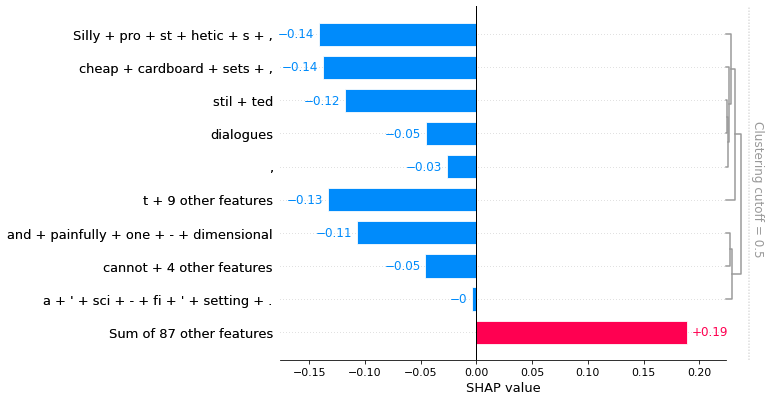

In [12]:
shap.plots.bar(shap_values[0,:,"POSITIVE"])

### A Deeper Dive on Shap

Multiple predictions - This is doing 2 predictions, but try a larger number, just know it will take a while to compute - about 2 minutes per explanation

In [13]:
## Multiple predictions at once:
shap_values = explainer(short_data[:2])


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 3it [04:34, 137.34s/it]


In [14]:
shap.plots.text(shap_values[:,:,"POSITIVE"])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


We can also aggregate the explanations to see what words show up the most across all the explanations.

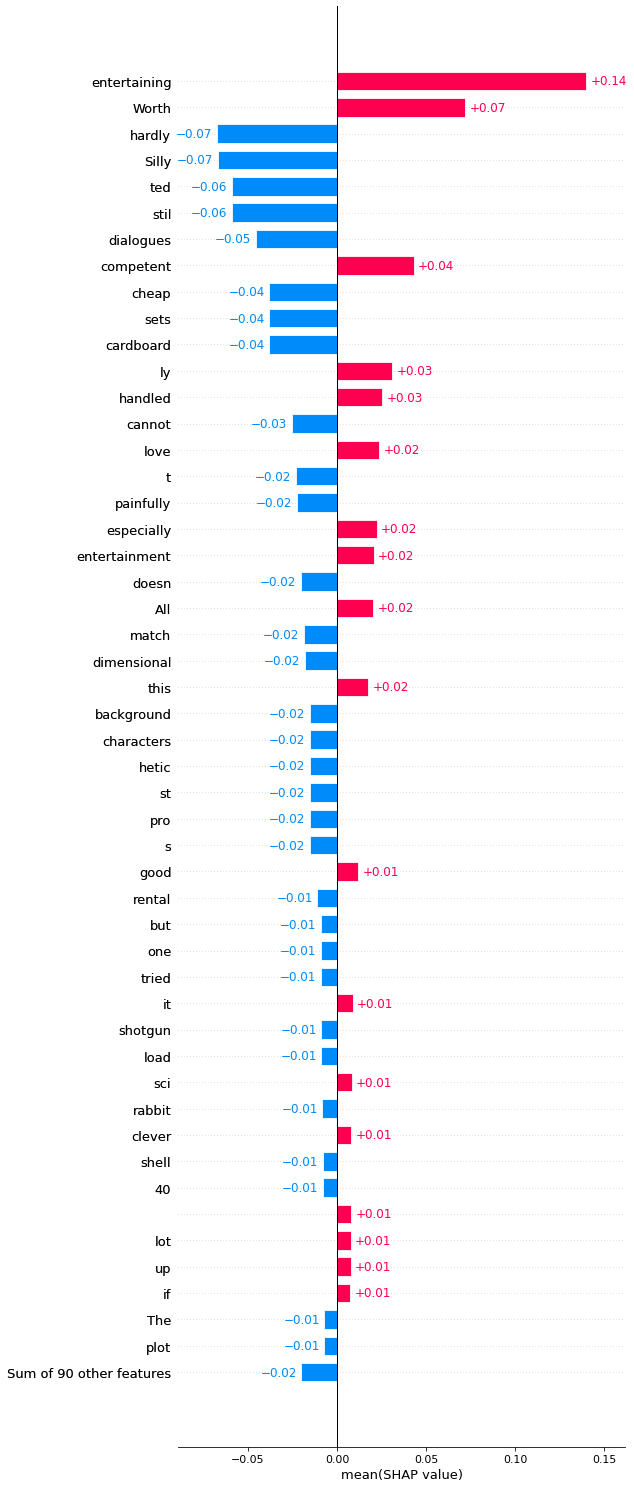

In [15]:

shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0),max_display=50)

### Understanding Partition Explainer
[Partition Explainer](https://shap.readthedocs.io/en/latest/generated/shap.explainers.Partition.html) is the Shap methodology that is used here. Let's dig into it a bit. I will start with a very short example, feel free to redo this later with a longer example.

In [16]:
test = ["I love sci-fi and eat a lot. you?"]
shap_values = explainer(test)

  0%|          | 0/182 [00:00<?, ?it/s]

Partition explainer: 2it [00:10, 10.95s/it]               


Notice how many iterations it ran for - smaller length here and ran less iterations

In [17]:
shap_values.feature_names[0]

['',
 'I',
 'love',
 'sci',
 '-',
 'fi',
 'and',
 'eat',
 'a',
 'lot',
 '.',
 'you',
 '?',
 '']

Partition explainer creates a hierarchical structure that it uses for the shap calculation.

In [18]:
cluster_matrix = shap_values.clustering
labels = list(shap_values.feature_names[0])

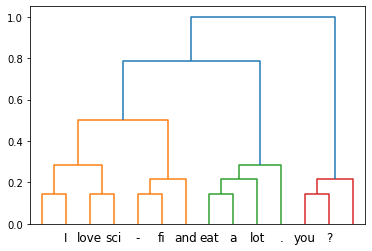

In [19]:
from scipy.cluster import hierarchy
hierarchy.dendrogram(cluster_matrix[0],labels=list(labels));

Here is the cluster matrix

In [20]:
shap_values.clustering[0]

array([[ 0.        ,  1.        ,  0.14285714,  2.        ],
       [ 2.        ,  3.        ,  0.14285714,  2.        ],
       [ 4.        ,  5.        ,  0.14285714,  2.        ],
       [ 7.        ,  8.        ,  0.14285714,  2.        ],
       [17.        ,  9.        ,  0.21428571,  3.        ],
       [11.        , 12.        ,  0.14285714,  2.        ],
       [14.        , 15.        ,  0.28571429,  4.        ],
       [16.        ,  6.        ,  0.21428571,  3.        ],
       [18.        , 10.        ,  0.28571429,  4.        ],
       [20.        , 21.        ,  0.5       ,  7.        ],
       [23.        , 22.        ,  0.78571429, 11.        ],
       [19.        , 13.        ,  0.21428571,  3.        ],
       [24.        , 25.        ,  1.        , 14.        ]])

## Transformer-Interpret

[Transformers Interpret](https://github.com/cdpierse/transformers-interpret) is a model explainability tool designed to work exclusively with the 🤗 transformers package. It uses Integrated Gradients (IG) and a variation of Layer Integrated Gradients (LIG) from [Captum](https://captum.ai/) as the core attribution methods.  
A demo of Transformer-Interpret can be found [here](https://huggingface.co/spaces/rajistics/interpet_transformers).

### Explanation predictions from a text classification model

In [21]:
from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)

The Integrated Gradients method is much quicker than the Parition Explainer. For more details on how Integrated Gradients work, check out this [tutorial](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients). It does a great job explaining the intuition and math behind calculating integrated gradients.

In [22]:
word_attributions = cls_explainer(short_data[0])

### Visualization Integrated Gradients Explanations

In [23]:
cls_explainer.visualize()

### A Deeper dive into Word Attributions

In [24]:
word_attributions

[('[CLS]', 0.0),
 ('i', -0.18409202865352994),
 ('love', -0.1079498984910787),
 ('sci', 0.07846091626863926),
 ('-', 0.1133937617541134),
 ('fi', 0.05602860351734083),
 ('and', -0.007496527619989617),
 ('am', 0.13481252090961934),
 ('willing', -0.05940254923293458),
 ('to', -0.04906692694873587),
 ('put', 0.07688134290193055),
 ('up', 0.049400164076926954),
 ('with', 0.003979142740491254),
 ('a', -0.09241999260694843),
 ('lot', -0.00703338554528742),
 ('.', 0.0007249244276450926),
 ('sci', 0.08328974647131267),
 ('-', 0.08305420114183117),
 ('fi', 0.043319245579393255),
 ('movies', 0.07451432300598897),
 ('/', 0.11914705053521096),
 ('tv', 0.09638534813624441),
 ('are', 0.10484256742892004),
 ('usually', 0.0001412320004833292),
 ('under', 0.06835170712808161),
 ('##fu', 0.14935190028815928),
 ('##nded', 0.03266511681069669),
 (',', 0.016167583275685404),
 ('under', 0.029192118174895084),
 ('-', 0.07345194056637054),
 ('appreciated', -0.05169827525591573),
 ('and', 0.061924459558263915)

Let's plot out the top word attributions 

In [25]:
def Sort_Tuple(tup):
    # reverse = None (Sorts in Ascending order)
    # key is set to sort using second element of
    # sublist lambda has been used
    tup.sort(key = lambda x: x[1])
    return tup

In [26]:
sorted = Sort_Tuple(word_attributions)

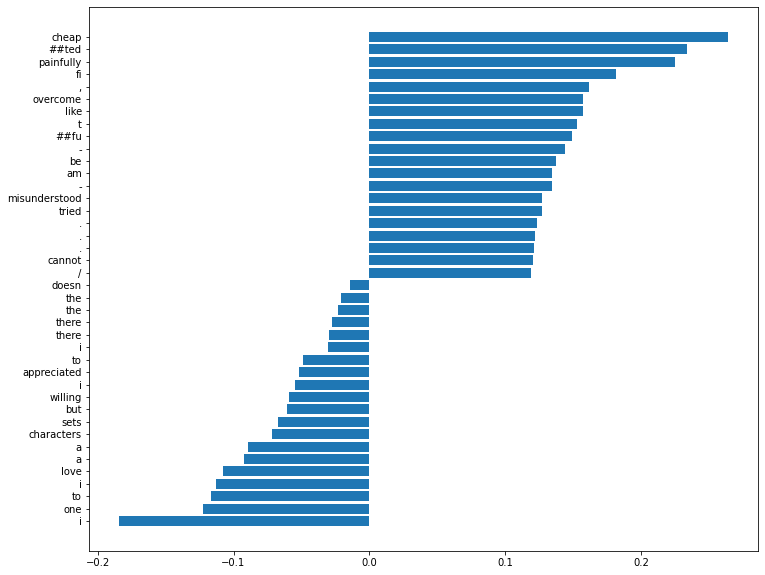

In [27]:
import matplotlib.pyplot as plt
labels, values = zip(*(sorted[:20] +sorted[-20:]))
plt.rcParams["figure.figsize"] = (12,10)
plt.barh(range(len(labels)),values)
plt.yticks(range(len(values)),labels)
plt.show()

## Ferret XAI 
Ferret is a python package for benchmarking interpretability techniques. They have published a [paper](https://arxiv.org/abs/2208.01575) explaining their framework, along with a [demo](https://huggingface.co/spaces/g8a9/ferret).


I like this package because it helps me compare different explanation methods. It will remind you that multiple explanation methods can differ!  Explanations for text are complicated and need to be appropriately caveated. It's easy to misuse these explanations.

This code snippet comes from the ferret documentation. I had trouble getting ferret to work on the IMDB model. It is using a binary classification sentiment model that has been fine-tuned on tweets.

In [28]:
from ferret import Benchmark
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")


### Explain predictions from a text classification model

In [29]:
bench = Benchmark(model, tokenizer)
explanations = bench.explain("You look stunning!", target=1)

Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Visualization Explanations
Ferret compares explanations from different methods. This can be very useful and very humbling to look across explanation methods. The methods include:

- Gradient (plain gradients or multiplied by input token embeddings) (Simonyan et al., 2014)
- Integrated Gradient (plain gradients or multiplied by input token embeddings) (Sundararajan et al., 2017)
- SHAP (via Partition SHAP approximation of Shapley values) (Lundberg and Lee, 2017)
- LIME (Ribeiro et al., 2016)

In [30]:
bench.show_table(explanations)

Token,▁You,▁look,▁stunning,!
Partition SHAP,-0.04,-0.28,-0.64,-0.04
LIME,0.10,0.04,-0.34,-0.01
Gradient,0.10,0.17,0.38,0.07
Gradient (x Input),0.18,0.22,0.42,0.10
Integrated Gradient,0.24,-0.13,0.11,-0.04
Integrated Gradient (x Input),-0.09,0.48,-0.11,0.32


### Evaluate Explanations

Ferret evaluates explanations using various metrics, they do have [a paper](https://arxiv.org/abs/2208.01575) that explains these metrics.

Faithfulness measures:
- AOPC Comprehensiveness (DeYoung et al., 2020)
- AOPC Sufficiency (DeYoung et al., 2020)
- Kendall’s Tau correlation with Leave-One-Out token removal. (Jain and Wallace, 2019)

Plausibility measures:
- Area-Under-Precision-Recall-Curve (soft score) (DeYoung et al., 2020)
- Token F1 (hard score) (DeYoung et al., 2020)
- Token Intersection Over Union (hard score) (DeYoung et al., 2020)


In [31]:
evaluations = bench.evaluate_explanations(explanations, target=1)
bench.show_evaluation_table(evaluations)

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.00,1.00,0.67
LIME,-0.07,-0.31,0.33
Gradient,-0.25,-0.09,-1.00
Gradient (x Input),-0.25,-0.09,-1.00
Integrated Gradient,-0.17,-0.22,0.00
Integrated Gradient (x Input),-0.07,-0.33,0.33


Ferret using the IMDB model, it takes a few minutes to get the explanations.  

In [ ]:
model2 = AutoModelForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb")
tokenizer2 = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb")
bench = Benchmark(model2, tokenizer2)
explanations = bench.explain(short_data[0])

In [39]:
bench.show_table(explanations)

,i,love,sci,-,fi,and,am,willing,to,put,up,with,a,lot,.,sci.1,-.1,fi.1,movies,/,tv,are,usually,under,##fu,##nded,",",under.1,-.2,appreciated,and.1,misunderstood,..1,i.1,tried,to.1,like,this,",.1",i.2,really,did,",.2",but,it,is,to.2,good,tv.1,sci.2,-.3,fi.2,as,babylon,5,is.1,to.3,star,trek,(,the,original,),..2,silly,pro,##st,##hetic,##s,",.3",cheap,cardboard,sets,",.4",stil,##ted,dialogues,",.5",c,##g,that,doesn,',t,match,the.1,background,",.6",and.2,painfully,one,-.4,dimensional,characters,cannot,be,overcome,with.1,a.1,'.1,sci.3,-.5,fi.3,'.2,setting,..3,(.1,i.3,'.3,m,sure,there,are.1,those,of,you,out,there.1,who,think,babylon.1,5.1,is.2,good.1,sci.4,-.6,fi.4
Partition SHAP,0.02,0.02,0.02,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.06,-0.01,-0.01,-0.01,-0.01,-0.01,-0.03,-0.03,-0.03,-0.02,-0.05,-0.05,-0.04,-0.02,-0.00,-0.00,-0.00,-0.02,-0.02,-0.02,-0.02,-0.02,-0.01,-0.00,-0.02,-0.02,-0.02,-0.02,-0.02,-0.01,-0.02,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,0.01,0.00,0.00
LIME,0.00,0.00,-0.00,0.01,-0.01,-0.01,-0.01,0.01,0.00,-0.01,0.00,0.01,-0.00,0.01,-0.02,-0.02,-0.01,-0.01,-0.02,0.00,-0.00,0.02,-0.01,-0.02,-0.01,0.00,-0.01,0.01,-0.00,-0.01,0.01,0.00,-0.01,0.01,0.00,-0.01,-0.00,-0.03,0.01,-0.01,-0.00,0.02,0.00,-0.03,0.00,0.00,-0.01,0.01,-0.00,0.01,0.00,-0.02,-0.01,-0.01,-0.01,-0.02,0.00,0.01,-0.01,0.00,-0.01,0.01,0.01,-0.02,-0.01,0.00,0.00,-0.01,-0.01,0.00,-0.02,-0.01,-0.01,0.01,-0.01,-0.01,-0.00,0.00,-0.01,0.00,-0.01,-0.02,0.00,-0.02,0.01,0.00,-0.01,-0.01,0.01,0.00,-0.02,-0.00,0.01,-0.01,0.00,-0.01,0.00,-0.00,-0.00,0.02,-0.01,0.01,-0.02,0.00,-0.01,0.00,-0.00,-0.00,-0.00,-0.01,-0.01,-0.01,-0.01,0.00,0.00,0.01,-0.01,-0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.01,-0.02,0.00
Gradient,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Gradient (x Input),0.00,-0.01,-0.01,0.01,-0.00,0.00,-0.00,-0.01,0.01,-0.00,-0.00,0.00,0.00,-0.01,0.00,-0.01,0.01,-0.00,-0.02,-0.00,-0.01,-0.00,-0.01,0.00,-0.02,-0.02,0.00,0.00,0.01,-0.00,0.00,-0.01,0.00,0.00,-0.00,0.01,-0.01,0.00,0.00,0.00,-0.01,0.00,0.00,0.00,0.00,0.00,0.01,-0.00,-0.01,-0.01,0.01,-0.00,0.00,-0.02,0.00,0.00,0.01,-0.01,-0.02,0.01,0.01,-0.01,0.00,0.00,-0.01,-0.00,-0.00,-0.04,0.00,0.00,-0.01,-0.02,-0.01,0.00,-0.01,0.00,-0.01,0.00,0.01,0.00,-0.00,-0.01,0.00,-0.01,-0.01,0.01,-0.02,0.00,0.00,-0.02,0.00,0.01,-0.03,-0.02,-0.00,0.00,-0.01,0.00,0.00,0.00,-0.01,0.01,-0.00,0.00,-0.00,0.00,0.01,0.00,0.00,-0.00,-0.01,0.00,-0.00,-0.00,0.01,-0.01,-0.00,0.00,0.00,-0.01,-0.02,0.00,0.00,-0.00,-0.01,0.01,-0.00
Integrated Gradient,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-

In [38]:
evaluations = bench.evaluate_explanations(explanations, target=1)
bench.show_evaluation_table(evaluations)

Explanation eval:   0%|          | 0/6 [00:00<?, ?it/s]

,aopc_compr,aopc_suff,taucorr_loo
Partition SHAP,0.06,-0.92,0.07
LIME,0.04,-0.85,0.04
Gradient,-0.59,-0.05,0.06
Gradient (x Input),-0.12,-0.51,-0.10
Integrated Gradient,0.00,1.00,-0.05
Integrated Gradient (x Input),-0.23,-0.46,0.03
